In [25]:
import moviepy.editor as mpy
import cv2
import numpy as np
from PIL import Image
import glob

In [448]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [210]:
import sklearn.metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.naive_bayes import GaussianNB

In [154]:
import random

# Предобработка данных

### Преобразование видео файла в набор изображений

In [2]:
def set_video(video_path: str):
        '''
        Получаем капчу по указанному пути
        
        Arguments:
        video_path, str - Путь к видео файлу
        
        Returns:
        capture, cv2.VideoCapture
        '''
        
        # Получаем клип и его fps
        video_clip = mpy.VideoFileClip(video_path)
        # Запоминаем fps
        fps = video_clip.fps
        # Запоминаем длительность видео в секундах
        duration = video_clip.duration
        
        # Запоминаем длину и ширину кадра в видео
        frame_size = video_clip.size

        # Получаем капчу клипа
        cap = cv2.VideoCapture(video_path)
        
        return cap

In [3]:
def viewImage(image, name_of_window = "window"):
    '''Вывод изображения на экран(для отладки)
    
    Arguments:
    image, numpy.ndarray - Изображение, полученное через cap.read()
    '''
    
    ##cv2.namedWindow(name_of_window, cv2.WINDOW_NORMAL)
    cv2.imshow(name_of_window, image)
    cv2.waitKey(0)
    
    cv2.destroyAllWindows()

In [68]:
def view_image_plt(image):
    '''Вывод изображения на экран
    
    Arguments:
    image, numpy.ndarray - Изображение, полученное через cap.read()
    '''
    plt.imshow(image)
    plt.show

In [22]:
def save_images(cap, N = 30, images_path = '../images/'):
    '''
    Сохраняем кадры из видео
    
    Arguments:
    cap, cv2.VideoCapture - Капча видеофайла,
    N, int - Каждый n-й кадр будет сохранятся
    
    Returns:
    n_frames, int - Число сохраненных кадров
    '''
    counter_of_frames = 0
    
    # Запускаем капчу
    while(cap.isOpened()):
        
        # Инкрементируем счетчик кадров
        counter_of_frames+=1
            
        ret, frame = cap.read() #ret - сообщ об отсуствии ошибок, frame - сам кадр
        
        # Выбираем каждый N-й кадр для сохранения
        if counter_of_frames % N == 0:
            # Сохраняем кадр
            im = Image.fromarray(frame)   
            im.save(images_path + "every " + str(N) + "th frame/" + str(counter_of_frames) + ".jpg") 
            
        # Блок останваливает обработку в конце файла или при нажатии клавиши "q"
        if cv2.waitKey(1) & 0xFF == ord('q') or ret == False:
            last_frame = frame
            break
        
    # "Освобождаем" капчу
    cap.release()
    cv2.destroyAllWindows()

#### Сохраняем каждый 30й кадр видеоролика

In [23]:
%%time
save_images(set_video('../videos/video_0.mp4'))

Wall time: 16min 50s


### Преобразование исходного датасета в числовые признаки

#### Получаем:
1) image (сами кадры), 

2) data (кадры в виде одномерных массивов), 

3) target (0/1 - значение целевого признака)


In [115]:
def get_set_of_numbers(begin: int, end: int):
    '''
    Возвращает set, сожержащий список чисел от begin до end включительно в формате строк
    
    Arguments:
    begin: int - Начало отсчета,
    end: int - Конец отсчета.
    
    returns:
    set of str - список от begin до end включительно в формате строк
    '''
    result = set()
    for x in range(begin, end + 1):
        result.add(str(x))
    return result

In [116]:
def get_gt_set(ground_truth_list):
    '''
    Возвращает set, сожержащий список чисел от begin до end включительно в формате строк
    
    Arguments:
    ground_truth_list - list, состоящий из интервалов фремов, в которых таргет = 1
    
    returns:
    set of str - список от begin до end включительно в формате строк
    '''
    result = set()
    
    for interval in ground_truth_list:
        result = result | get_set_of_numbers(interval[0], interval[1])
    return result

In [152]:
def read_images(file_path: str, dsize_coef = 4):
    '''
    Получает все кадры из папки
    
    Arguments:
    file_path, str - относительный путь к папке с картинками,
    dsize_coef, int - коэффициент сжатия кадра.
    
    returns:
    array of images - (image: np.ndarray),
    
    '''
    
    # Собираем из файла все названия картинок
    names = [name for name in glob.glob( file_path + "/*.jpg")]
    
    # Ручная разметка данных
    gt = ((180, 300), (360, 480), (3660, 3780), (4140, 4230), (6960, 7110), (7320, 7650), (7860, 8010), (9780, 9870),
         (10560, 11220), (12420, 12600), (12780, 12990), (13080, 13140), (19680, 19800), (22500, 22596), (23670, 23760), (30240, 30450),
         (32880, 32970), (33750, 33870), (33960, 34110), (36000, 36300), (36480, 36750), (37260, 37440), (37710, 37800), (38040, 38250),
         (38640, 38880), (39480, 39630), (43080, 43170), (43410, 43530), (44790, 44970), (45990, 46080), (47970, 48090), (48420, 48510))
    # Записываем сет всех кадров, в которых таргет = 1
    gt_set = get_gt_set(gt)
    
    images = []
    target = []
    data = []
    
    # Такая сложность из-за проблемы чтения русских символов библиотекой cv2
    
    # Для каждого пути получаем картинку
    for name in names:
        
        # Определяем номер считываемого кадра
        name_number = name.split('\\')[1].split('.')[0]
        
        # Если мы выббрали кадр, номер которого содержится в gt, помечаем его как целевой
        if name_number in gt_set:
            target.append(1)
        else:
            target.append(0)
        
        f = open(name, "rb")
        chunk = f.read()
        chunk_arr = np.frombuffer(chunk, dtype=np.uint8)
        img = cv2.imdecode(chunk_arr, cv2.IMREAD_COLOR)
        
        res_img = cv2.resize(img, dsize=(int(img.shape[1] / dsize_coef), int(img.shape[0] / dsize_coef)), interpolation=cv2.INTER_CUBIC)
        
        data_l = res_img.flatten()
        
        images.append(res_img)
        
        data.append(data_l)
        
    return np.array(images), np.array(target), np.array(data)

#### Получаем данные из папки

In [153]:
%%time
images, target, data = read_images("../images/every 30th frame")

Wall time: 31.2 s


#### Наблюдается явный дисбаланс классов => использование accuracy не подходит в качестве метрики классификации

In [155]:
np.unique(target, return_counts=True)

(array([0, 1]), array([1473,  208], dtype=int64))

#### Всего в нашем датасете будет 1681 кадр, которые мы будем обрабатывать

In [156]:
len(images)

1681

In [157]:
images[0].shape

(320, 180, 3)

In [158]:
data.shape

(1681, 172800)

#### Выведем изображение с меткой 0

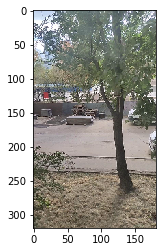

In [159]:
view_image_plt(images[1615])

#### А также изображние с меткой 1

In [342]:
len(np.where(np.array(target) == 1)[0])

208

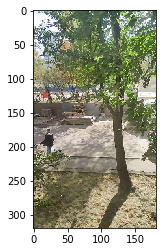

In [175]:
view_image_plt(images[random.choice(np.where(np.array(target) == 1)[0])])

#### Как видим, на кадре действительно хорошо заметен силуэт человека

## Разделение выборки на обучающую и тестовую

In [196]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)

In [335]:
X_train.shape

(1344, 172800)

In [336]:
X_test.shape

(337, 172800)

In [197]:
np.where(y_test == 1)[0].shape

(38,)

In [199]:
y_test

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,

в тестовой выборке целевой класс представлен примерно в том же соотношении, что и в обучающей выборке

# Построение моделей

### Для начала посмотрим на результаты работы классических моделей без настройки гиперпараметров

#### В качестве метрики используем F1 меру, так как она дает некий баланс между precision и recall

#### Так как тренировка модели идет слишком долго, уменьшим размер выборки

In [216]:
from sklearn.model_selection import KFold

In [221]:
kf = KFold(n_splits=3)
folds = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    
    folds.append({"X_train_fold": X_train_fold, "y_train_fold": y_train_fold, 
                  "X_test_fold": X_test_fold, "y_test_fold": y_test_fold})

In [227]:
folds[0]['X_train_fold'].shape

(896, 172800)

In [228]:
folds[0]['X_test_fold'].shape

(448, 172800)

#### Чтобы уменьшить фактор случайности, оценивать эффективность будем на сross validation

In [229]:
%%time
models = [
    ("SVM", SVC()),
    ("KNN", KNN()),
    ("LogisticRegression", LogisticRegression()),
    ("DecisionTree", Tree(max_depth= 50)),
    ("GaussianNB", GaussianNB()),
         ]
result = {}

for name, model in models:
    mean_score = cross_val_score(model, folds[0]['X_train_fold'], folds[0]['y_train_fold'], cv=3, scoring='f1').mean()
    result[name] = mean_score
    print(name, str(mean_score))

SVM 0.0
KNN 0.2710554860241969
LogisticRegression 0.4901343239387332
DecisionTree 0.5338439338439338
GaussianNB 0.46822429906542057
Wall time: 15min 19s


Стоит отметить, что эти алгоритмы крайне плохо работают in box (т.е. без настройки гиперпараметров)

Лучший результат показал алгоритм дерева решений, с небольшим отставанием идет логистическая регрессия и наивный Байес

##### Попробуем ансамблевые модели, основанные на деревьях решений. Они лучше работают in box, а также имеют преимущество за счет использования большого числа моделей. Это дает право думать, что данные методы будут работать значительно лучше

Однако, ансамблевые методы работают в кратное количество раз дольше, поскольку используют множество простых моделей

Поэтому, модель будем обучать на 1/3 части обучающей выборки, а проведем оценку на всей обучающей выборке. Кроме того, зададим n_estimators меньше стандартного

In [230]:
from sklearn.ensemble import GradientBoostingClassifier

In [234]:
%%time
model_GBC = GradientBoostingClassifier()

model_GBC.fit(folds[1]['X_train_fold'], folds[1]['y_train_fold'])

Wall time: 58min 15s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [255]:
score_GBC_fold_1 = sklearn.metrics.f1_score(folds[1]['y_test_fold'], model_GBC.predict(folds[1]['X_test_fold']))

print("GradientBoostingClassifier result: ", score_GBC_fold_1)

GradientBoostingClassifier result:  0.43373493975903615


In [267]:
score_GBC_fold_2 = sklearn.metrics.f1_score(folds[2]['y_test_fold'], model_GBC.predict(folds[2]['X_test_fold']))
score_GBC_fold_0 = sklearn.metrics.f1_score(folds[0]['y_test_fold'], model_GBC.predict(folds[0]['X_test_fold']))

In [270]:
GBC_result = np.mean([score_GBC_fold_0, score_GBC_fold_1, score_GBC_fold_2])
GBC_result

0.8112449799196787

#### Средний показатель метрики действительно улучшился за счет хороших предсказаний на 2х других фолдах

Проверим также на отложенной выборке

In [446]:
test_score_GBC = sklearn.metrics.f1_score(y_test, model_GBC.predict(X_test))
test_score_GBC

0.32

Результаты значительно хуже, что может говорить о переобучении модели на тренировочных данных. Это легко объянимо тем, что мы дали модели малое количество данных ради увеличения скорости работы.

## Улучшение моделей методом подбора улчших гиперпараметрво

#### Логистическая регрессия

In [338]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

In [344]:
%%time
model = LogisticRegression(solver= 'saga', random_state=42)
parameters = {'penalty' : ['l1', 'l2', 'elasticnet'],
             'C': uniform(loc=0, scale=4).rvs(size = 4) }

clf = RandomizedSearchCV(model, parameters, random_state= 42, cv= 3)
search = clf.fit(X_train, y_train)

search.best_params_

Wall time: 1h 23min 41s


{'penalty': 'l2', 'C': 2.4275208923645204}

In [358]:
sklearn.metrics.f1_score(y_train, search.predict(X_train) )

0.988095238095238

In [346]:
sklearn.metrics.f1_score(y_test, search.predict(X_test) )

0.5098039215686275

Наблюдается переобучение алгоритма

Попробуем усилить регуляризацию

In [364]:
%%time
model_logReg = LogisticRegression(solver= 'saga', penalty= 'l2', C= 0.001,  random_state=42)

model_logReg.fit(X_train, y_train)

print('train score: ', sklearn.metrics.f1_score(y_train, model_logReg.predict(X_train) ) )
print('test score: ', sklearn.metrics.f1_score(y_test, model_logReg.predict(X_test) ) )

train score:  0.988095238095238
test score:  0.5098039215686275
Wall time: 4min 13s


Вывод: усиление регуляризации не помогло

#### Дерево решений

In [347]:
%%time
model_tree = Tree(random_state=42)
parameters_tree = {'criterion' : ['gini', 'entropy'],
             'max_depth': uniform(loc=10, scale=100).rvs(size = 5) }

clf_tree = RandomizedSearchCV(model_tree, parameters_tree, random_state= 42, cv= 3)
search_tree = clf_tree.fit(X_train, y_train)

search_tree.best_params_

Wall time: 1h 21min 23s


{'max_depth': 102.81738885672134, 'criterion': 'gini'}

In [357]:
sklearn.metrics.f1_score(y_train, search_tree.predict(X_train) )

1.0

In [356]:
sklearn.metrics.f1_score(y_test, search_tree.predict(X_test) )

0.6111111111111113

Результаты на тестовой выборки заметно хуже, что говорит о переобучении

Попробуем уменьшить глубину дерева

In [365]:
%%time
model_DecisionTree = Tree(criterion= 'gini', max_depth= 10,  random_state=42)

model_DecisionTree.fit(X_train, y_train)

print('train score: ', sklearn.metrics.f1_score(y_train, model_DecisionTree.predict(X_train) ) )
print('test score: ', sklearn.metrics.f1_score(y_test, model_DecisionTree.predict(X_test) ) )

train score:  0.8338983050847457
test score:  0.46153846153846156
Wall time: 2min 30s


Вывод: уменьшение глубины дерева не помогло. Ухудшилось качество модели как на тренировочной, так и на тестовой выбоке

#### Наивный байес

In [343]:
from sklearn.model_selection import GridSearchCV

In [350]:
%%time
model_bayes = GaussianNB()
parameters_bayes = {'priors' : [None, [0.876, 0.124]]}

clf_bayes = GridSearchCV(model_bayes, parameters_bayes, cv= 3)
search_bayes = clf_bayes.fit(X_train, y_train)

search_bayes.best_params_

Wall time: 1min 36s


{'priors': None}

In [359]:
sklearn.metrics.f1_score(y_train, search_bayes.predict(X_train) )

0.4728434504792333

In [354]:
sklearn.metrics.f1_score(y_test, search_bayes.predict(X_test) )

0.3795620437956205

Алгоритм показал более плохие результаты, чем дерево решений и логистическая регрессия. К тому же наблюдается переобучение, хоть и менее выраженная, чем в других моделях

### Вывод: Все примененные модели обучаются крайне долго, при этом легко переобучаясь

Возможные варианты решения проблемы:

1) Нормализовать данные

2) Использовать вместо 3х RGB каналов градации серого

3) Применить какой-либо алгоритм выделения границ объекта

#### Пробуем нормализовать данные и применить фильтр градаций серого

In [422]:
def rgb2gray(img):
    '''
    Переводит RGB изображение к формату градаций серого
    
    Arguments:
    image, numpy.ndarray - изображение в формате rgb
    
    returns:
    gray_image, numpy.ndarray -  изображение в формате градаций серого
    '''
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    
    return imgGray

In [423]:
%%time
# Приведение к градациям серого
print('Форма массива rgb кадров', images.shape)
gray_images = []
gray_data = []

for image in images:
    gray_img = rgb2gray(image)
    gray_images.append(gray_img)
    gray_data.append(gray_img.flatten())
    
    
gray_images = np.array(gray_images)
gray_data = np.array(gray_data)
    
print('Форма массива серых кадров', gray_images.shape)

Форма массива rgb кадров (1681, 320, 180, 3)
Форма массива серых кадров (1681, 320, 180)
Wall time: 2.68 s


In [425]:
data.shape

(1681, 172800)

In [426]:
gray_data.shape

(1681, 57600)

Изображние в градациях серого

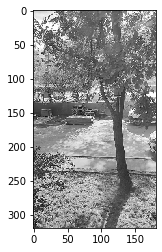

In [427]:
plt.imshow(gray_images[0], cmap='gray')
plt.show()

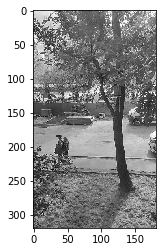

In [428]:
plt.imshow(gray_images[random.choice(np.where(np.array(target) == 1)[0])],
           cmap='gray')
plt.show()

In [384]:
from sklearn.preprocessing import Normalizer

In [429]:
# Нормализация данных

gray_normalize_dada = Normalizer().fit_transform(gray_data)
gray_normalize_dada.shape

(1681, 57600)

### Пробуем натренировать модель на новых данных

In [436]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(gray_normalize_dada, 
                                                            target, 
                                                            test_size = 0.2, 
                                                            random_state = 0)

In [437]:
X_train_1.shape

(1344, 57600)

### Тренируем модель дерева решений

In [486]:
%%time
model_tree_new_data = Tree(random_state=42)
parameters_tree = {'criterion' : ['gini', 'entropy'],
             'max_depth': [50, 100, 150] }

GS_tree = GridSearchCV(model_tree_new_data, parameters_tree, cv= 3)

search_tree_new_data = GS_tree.fit(X_train_1, y_train_1)

search_tree_new_data.best_params_

Wall time: 23min 52s


{'criterion': 'gini', 'max_depth': 50}

In [487]:
train_f1_tree_norm = sklearn.metrics.f1_score(y_train_1, search_tree_new_data.predict(X_train_1) )
test_f1_tree_norm = sklearn.metrics.f1_score(y_test_1, search_tree_new_data.predict(X_test_1) )

In [490]:
train_f1_tree_norm

1.0

In [491]:
test_f1_tree_norm

0.5714285714285715

К сожалению, от переобучения избавиться не удалось

## Визуализация результатов

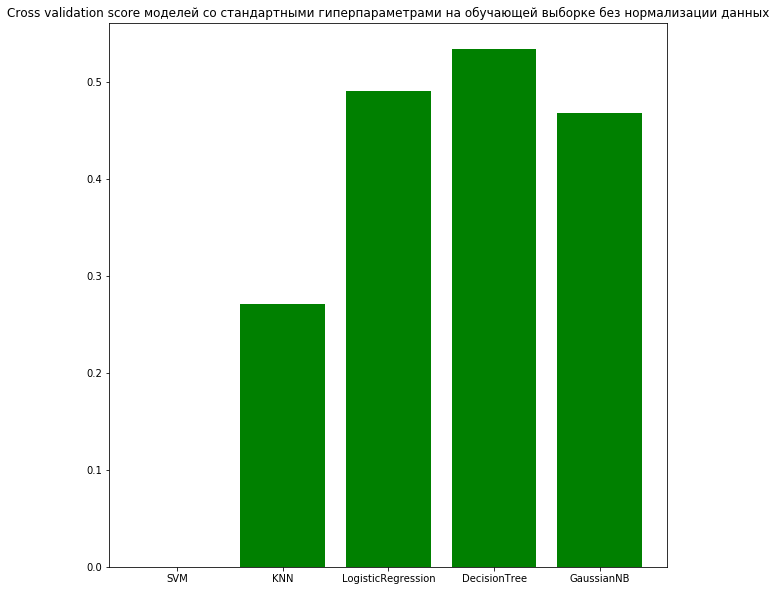

In [504]:
plt.subplots(figsize=(10, 10))
plt.bar(list(result.keys()), result.values(), color='g')
plt.title('Сross validation score моделей со стандартными гиперпараметрами на обучающей выборке без нормализации данных')
plt.show()

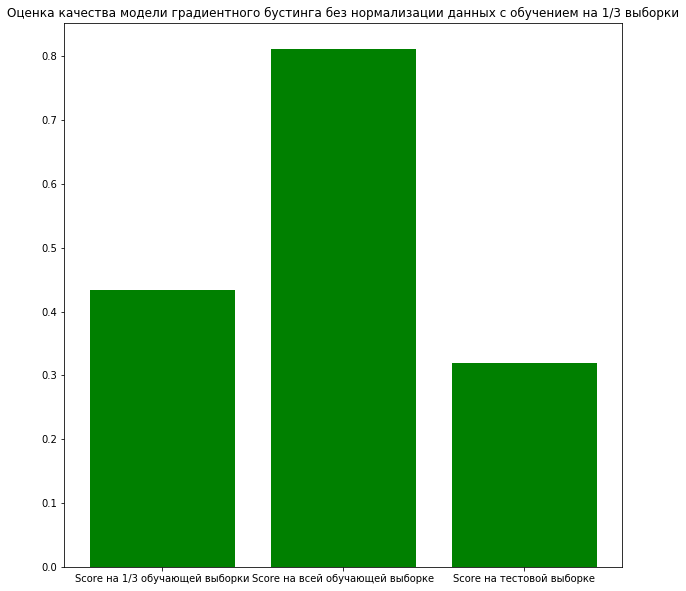

In [503]:
plt.subplots(figsize=(10, 10))
plt.bar(['Score на 1/3 обучающей выборки', 'Score на всей обучающей выборке', 'Score на тестовой выборке'], [score_GBC_fold_1, GBC_result, test_score_GBC], color='g')
plt.title('Оценка качества модели градиентного бустинга без нормализации данных с обучением на 1/3 выборки')
plt.show()

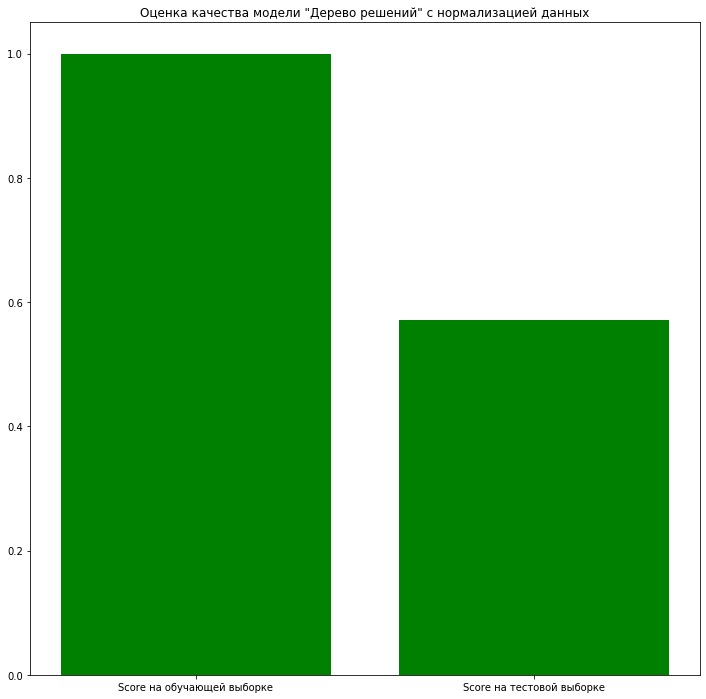

In [502]:
plt.subplots(figsize=(12, 12))
plt.bar(['Score на обучающей выборке', 'Score на тестовой выборке'], [train_f1_tree_norm, test_f1_tree_norm], color='g')
plt.title('Оценка качества модели "Дерево решений" с нормализацией данных')
plt.show()